# OCR model for reading captchas 
### This is a basic example of using the OCR model to read captchas

In [11]:
# libraries
import os
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from keras import layers

# Download the dataset

In [12]:
url = 'https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip'
response = requests.get(url)

with open('captcha_images_v2.zip', 'wb') as f:
    f.write(response.content)
    
with zipfile.ZipFile('captcha_images_v2.zip', 'r') as w:
    w.extractall()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

 66 8863k   66 5890k    0     0  9421k      0 --:--:-- --:--:-- --:--:-- 9421k
100 8863k  100 8863k    0     0  10.0M      0 --:--:-- --:--:-- --:--:-- 12.0M


In [13]:
# Path to the data directory
data_dir = Path('./captcha_images_v2/')

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob('*.png')))))
labels = [img.split(os.path.sep)[-1].split('.png')[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print(f'Number of images found: {len(images)}')
print(f'Number of labels found: {len(labels)}')
print(f'Number of unique characters: {len(characters)}')
print(f'Characters present: {characters}')

Number of images found: 1040
Number of labels found: 1040
Number of unique characters: 19
Characters present: ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


# Preprocessing


In [14]:
# Mapping characters to integers
charToNum = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
numToChar = layers.StringLookup(
    vocabulary=charToNum.get_vocabulary(), mask_token=None, invert=True
)

In [15]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    training = int(size * train_size)
    # 4. Split data into training and validation sets
    xTraining, yTraining = images[indices[:training]], labels[indices[:training]]
    xValid, yValid = images[indices[training:]], labels[indices[training:]]
    return xTraining, xValid, yTraining, yValid

In [16]:
# Splitting data into training and validation sets
xTraining, xValid, yTraining, yValid = split_data(np.array(images), np.array(labels))

In [17]:
def encode_single_sample(img_path, label):

    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [50, 200])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = charToNum(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

# Creating dataset objects

In [18]:
#Training dataset
trainingDataset = tf.data.Dataset.from_tensor_slices((xTraining, yTraining))
trainingDataset = (
    trainingDataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(16)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

#Validation Dataset
validationDataset = tf.data.Dataset.from_tensor_slices((xValid, yValid))
validationDataset = (
    validationDataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(16)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Visualize the data

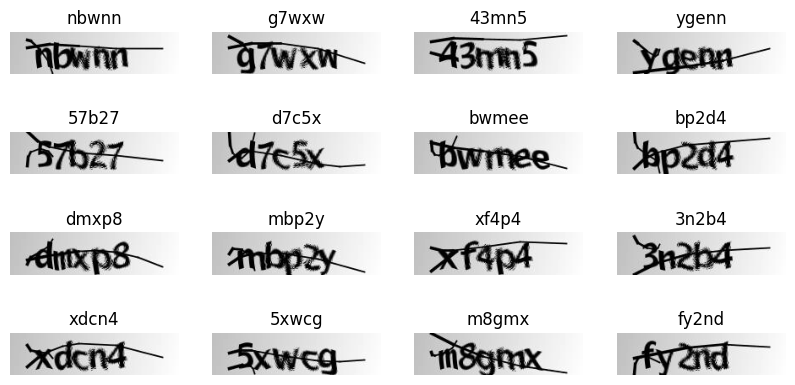

In [19]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in trainingDataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(numToChar(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Creating the model

In [20]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, yCorrect, yPredict):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batchLen = tf.cast(tf.shape(yCorrect)[0], dtype="int64")
        inputLength = tf.cast(tf.shape(yPredict)[1], dtype="int64")
        labelLength = tf.cast(tf.shape(yCorrect)[1], dtype="int64")

        inputLength = inputLength * tf.ones(shape=(batchLen, 1), dtype="int64")
        labelLength = labelLength * tf.ones(shape=(batchLen, 1), dtype="int64")

        loss = self.loss_fn(yCorrect, yPredict, inputLength, labelLength)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return yPredict

In [21]:
def build_model():
    # Inputs to the model
    inputImage = layers.Input(
        shape=(200, 50, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(inputImage)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    new_shape = ((200 // 4), (50 // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(charToNum.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[inputImage, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

In [22]:
# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

# Training the model

In [23]:
epochs = 100
earlyStop = 10
# Add early stopping
earlyStoppingCallback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=earlyStop, restore_best_weights=True
)

# Train the model
history = model.fit(
    trainingDataset,
    validation_data=validationDataset,
    epochs=epochs,
    callbacks=[earlyStoppingCallback],
)

Epoch 1/100
59/59 [==============================] - 14s 144ms/step - loss: 20.7180 - val_loss: 16.5172
Epoch 2/100
59/59 [==============================] - 7s 112ms/step - loss: 16.3439 - val_loss: 16.4796
Epoch 3/100
59/59 [==============================] - 7s 120ms/step - loss: 16.3350 - val_loss: 16.4682
Epoch 4/100
59/59 [==============================] - 8s 140ms/step - loss: 16.3249 - val_loss: 16.4724
Epoch 5/100
59/59 [==============================] - 8s 132ms/step - loss: 16.3214 - val_loss: 16.4699
Epoch 6/100
59/59 [==============================] - 7s 125ms/step - loss: 16.3160 - val_loss: 16.4603
Epoch 7/100
59/59 [==============================] - 7s 119ms/step - loss: 16.3081 - val_loss: 16.4549
Epoch 8/100
59/59 [==============================] - 7s 120ms/step - loss: 16.3034 - val_loss: 16.4464
Epoch 9/100
59/59 [==============================] - 7s 113ms/step - loss: 16.2970 - val_loss: 16.4377
Epoch 10/100
59/59 [==============================] - 7s 112ms/step - lo

# Inference

In [24]:
# Get the prediction model by extracting layers till the output layer
predModel = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
predModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

In [33]:
# Maximum length of any captcha in the dataset
maxLength = max([len(label) for label in labels])

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :maxLength]
    # Iterate over the results and get back the text
    outputTxt = []
    for res in results:
        res = tf.strings.reduce_join(numToChar(res)).numpy().decode("utf-8")
        outputTxt.append(res)
    return outputTxt

1/1 [==============================] - 0s 44ms/step


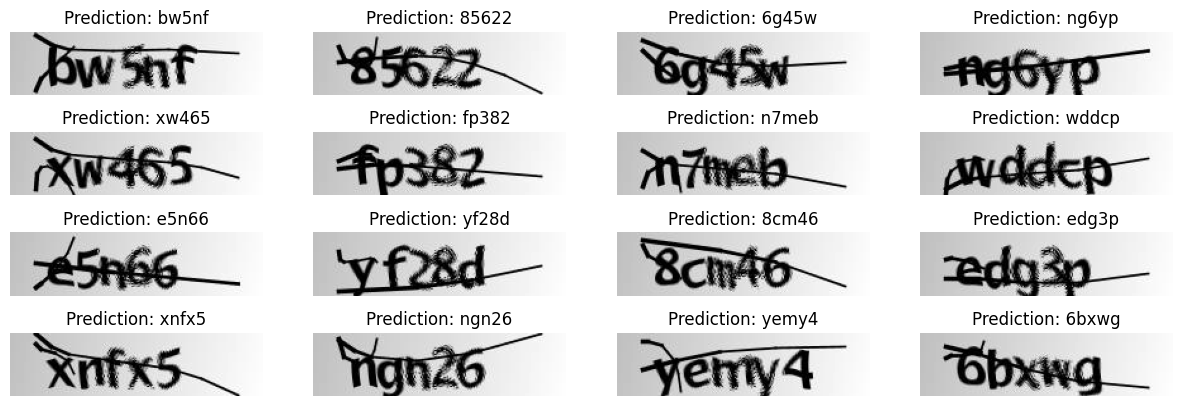

In [34]:
# Check the results on some validation samples
for batch in validationDataset.take(1):
    batchImg = batch["image"]
    batchLabels = batch["label"]

    preds = predModel.predict(batchImg)
    predTexts = decode_batch_predictions(preds)

    originalTexts = []
    for label in batchLabels:
        label = tf.strings.reduce_join(numToChar(label)).numpy().decode("utf-8")
        originalTexts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(predTexts)):
        img = (batchImg[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {predTexts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()